In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_context('talk')

SAS_FILE_DIRECTORY = '/media/elvyna/DATA/sas/SASUniversityEdition/myfolders/dataset/sas-processed/'

# Combine Processed Activpal Data from SAS


In [37]:
df_activpal = pd.DataFrame()

for directory_name in os.listdir(SAS_FILE_DIRECTORY):
    for subdirectory_content in os.listdir(SAS_FILE_DIRECTORY + directory_name):
        if subdirectory_content.endswith('.csv'):
            print(subdirectory_content)
            df = pd.read_csv(SAS_FILE_DIRECTORY + directory_name + '/' + subdirectory_content)
            df_activpal = pd.concat([df_activpal, df])

In [19]:
# df_activpal = df_activpal[(df_activpal['patient_id'].isin([17, 23]))].copy()

# df_activpal.loc[
#     (df_activpal['patient_id'] == 17),
#     'patient_id'
# ] = 1

# df_activpal.loc[
#     (df_activpal['patient_id'] == 23),
#     'patient_id'
# ] = 2

In [3]:
## reference: https://stackoverflow.com/questions/29387137/how-to-convert-a-given-ordinal-number-from-excel-to-a-date
from datetime import datetime, timedelta

def from_excel_ordinal(ordinal, _epoch0=datetime(1899, 12, 31)):
    if ordinal >= 60:
        ordinal -= 1  # Excel leap year bug, 1900 is not a leap year!
    return (_epoch0 + timedelta(days=ordinal)).replace(microsecond=0)

In [4]:
df_activpal['datetime'] = df_activpal['time'].apply(from_excel_ordinal)
df_activpal['datetime_hour'] = df_activpal['datetime'].dt.floor('h')
df_activpal['hour'] = df_activpal['datetime'].dt.hour

df_activpal['date'] = pd.to_datetime(
    pd.to_datetime(df_activpal['datetime']).dt.date
)
df_activpal['date_noon'] = df_activpal['date'] + np.timedelta64(12,'h')

df_activpal['visit_info'] = df_activpal['visit_info'].str.lower().str.replace(' ','-')

In [23]:
df_activpal.shape

(80030, 68)

In [29]:
df_activpal.columns

Index(['time', 'datacount_samples', 'interval_s', 'activity_code',
       'cumulativestepcount', 'activity_score_met_h', 'patient_id',
       'visit_info', 'boutid', 'sasdatetimenumber', 'steps_n', 'boutidR',
       'sasdatetimenumber_endbout', 'interval_s_derived', 'basicdate',
       'noondate', 'maxboutdur_nd', 'longestbout', 'sleepbout', 'sitting_s',
       'standing_s', 'stepping_s', 'active_s', 'nonstep_s', 'prnonstep2h_s',
       'prnonstep30m_s', 'slnum', 'sleepboutall', 'slnumR', 'sleepboutF',
       'sleepboutB', 'AW_sitting_t', 'AW_standing_t', 'AW_stepping_t',
       'AW_active_t', 'AW_all_t', 'AW_steps_n', 'SL_sitting_t',
       'SL_standing_t', 'SL_stepping_t', 'SL_active_t', 'SL_all_t',
       'SL_steps_n', 'AW_sitting_t_TOT', 'AW_standing_t_TOT',
       'AW_stepping_t_TOT', 'AW_active_t_TOT', 'AW_all_t_TOT',
       'SL_sitting_t_TOT', 'SL_standing_t_TOT', 'SL_stepping_t_TOT',
       'SL_active_t_TOT', 'SL_all_t_TOT', 'AW_sitting_t_TOTPCT',
       'AW_standing_t_TOTPCT',

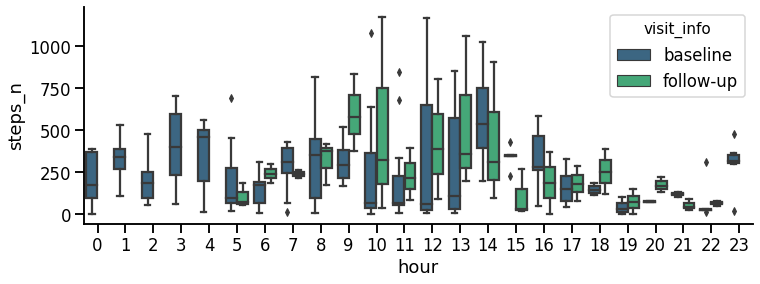

In [26]:
mask_valid = (df_activpal['validday'] == 1) & (df_activpal['sleepboutall'] != 1)

d = df_activpal[mask_valid].groupby([
    'patient_id',
    'visit_info',
    'date',
    'hour'
]).agg({
    'AW_steps_n':'sum',
    'SL_steps_n':'sum',
    'steps_n':'sum'
}).reset_index()

f, ax = plt.subplots(figsize=(12,4))
sns.boxplot(
    data=d,
    x='hour',
    y='steps_n',
    hue='visit_info',
    palette='viridis'
);
sns.despine();

# Merge with patient metadata

In [8]:
df_patient_metadata = pd.read_csv('../0-dataset/1-preprocessed/patient_metadata_trimmed.csv')
df_patient_metadata['visit_info'] = np.where(
    (df_patient_metadata['visit'] == 1),
    'baseline',
    'follow-up'
)

In [9]:
conditions = [
    (df_patient_metadata['gender'] == 1),
    (df_patient_metadata['gender'] == 0)
]

choices = [
    'female',
    'male'
]

df_patient_metadata['gender_string'] = np.select(
    conditions,
    choices,
    default = None
)

In [31]:
## combine with main metadata of the patient
meta = df_patient_metadata.loc[
    (df_patient_metadata['visit'].notnull()),
    [
        'patient_id','visit_info','include_activpal_data','gender_string','age','height','weight','bmi',
        'sf_pf', 'sf_role', 'sf_pain','sf_social', 'sf_mental', 'sf_emot', 'sf_vitality', 
        'sf_gen_health','sf36_total', 'haq','ntx','oc'
    ]
].copy().rename(
    columns = {
        'gender_string': 'gender',
        'sf_pf': 'sf_physical_functioning',
        'sf_role': 'sf_role_physical',
        'sf_pain': 'sf_bodily_pain',
        'sf_social': 'sf_social_functioning',
        'sf_mental': 'sf_mental_health',
        'sf_emot': 'sf_role_emotional',
        'sf_gen_health': 'sf_general_health'
    }
)

df_activpal = df_activpal.merge(
    meta,
    how = 'left',
    left_on = ['patient_id','visit_info'],
    right_on = ['patient_id','visit_info']
)

In [36]:
# df_activpal.to_csv('../0-dataset/1-preprocessed/activpal_combined_slnw_with_metadata.csv', index=False)